In [1]:
import os, time, cv2, math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cv2
from skimage.morphology import disk
from skimage.filters import median

import konfokal_lib as kl

img_nr = 0

In [2]:
home_dir = os.path.abspath("") + os.sep

files = { 'before': { 'filename': 'C3S-Balken z-Daten_vorher.asc', 'clip_min':-25000, 'clip_max':15000},
		  'after': { 'filename': 'C3S-Balken z-Daten_nachher.asc', 'clip_min':-25000, 'clip_max':15000} }

loading 'C3S-Balken C3S-Balken z-Daten_vorher.asc'


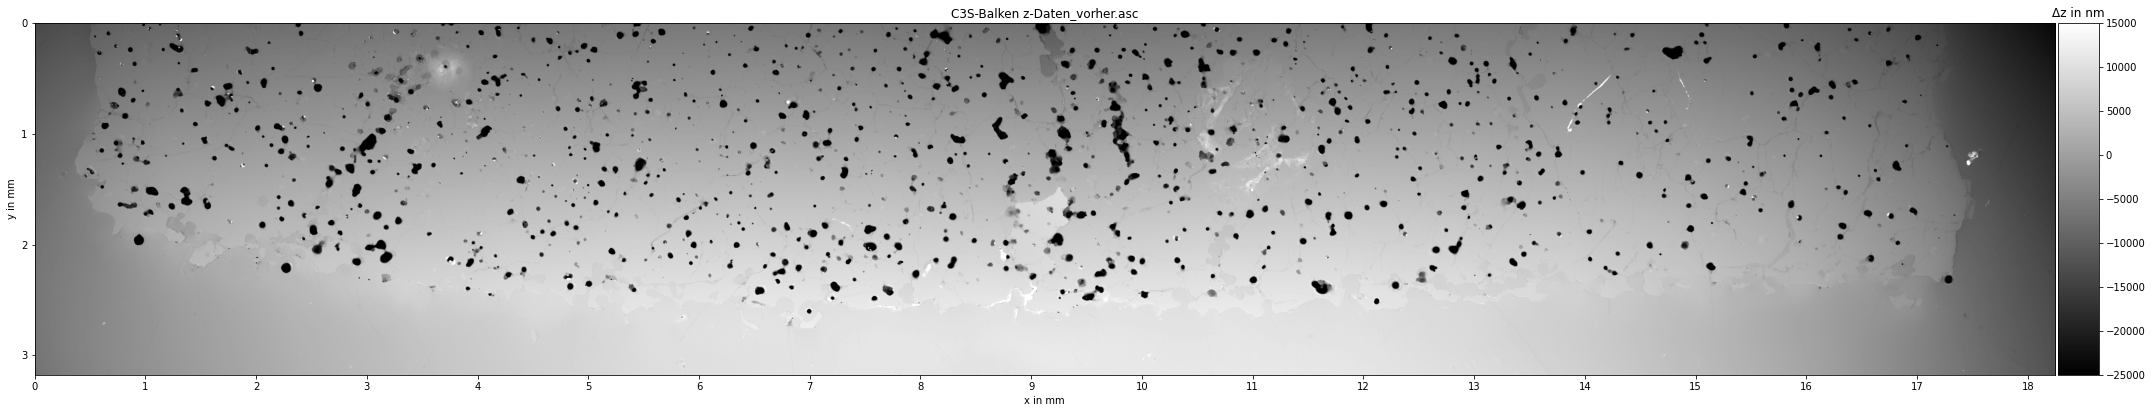

x/y-scale: 1289.476 nm/px
dataset size: 3177270.0 x 18244802.4 nm (2464 x 14149 px)
Min: -168136, Max: 92664, Mean: -0.000527


In [3]:
files['before'] = kl.load_file(files['before'])

loading 'C3S-Balken C3S-Balken z-Daten_nachher.asc'


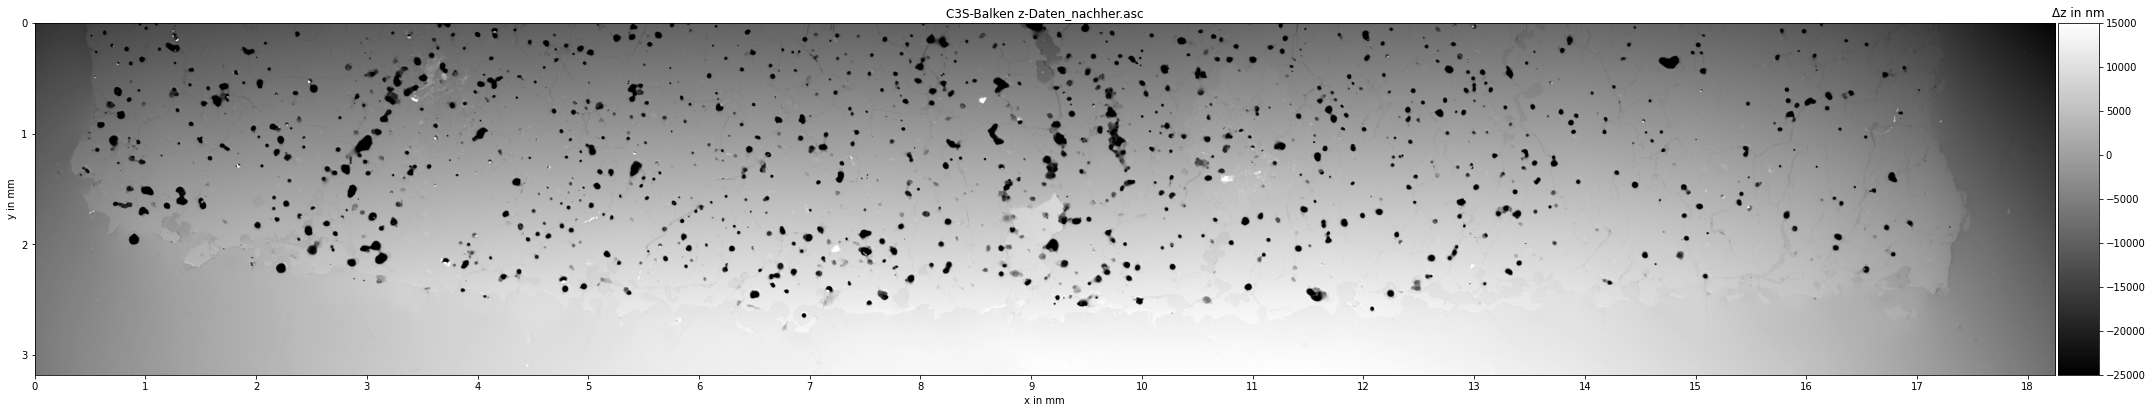

x/y-scale: 1289.477 nm/px
dataset size: 3178560.0 x 18244805.5 nm (2465 x 14149 px)
Min: -125275, Max: 54998, Mean: 0.004057


In [4]:
files['after'] = kl.load_file(files['after'])

Found 268 matching point pairs


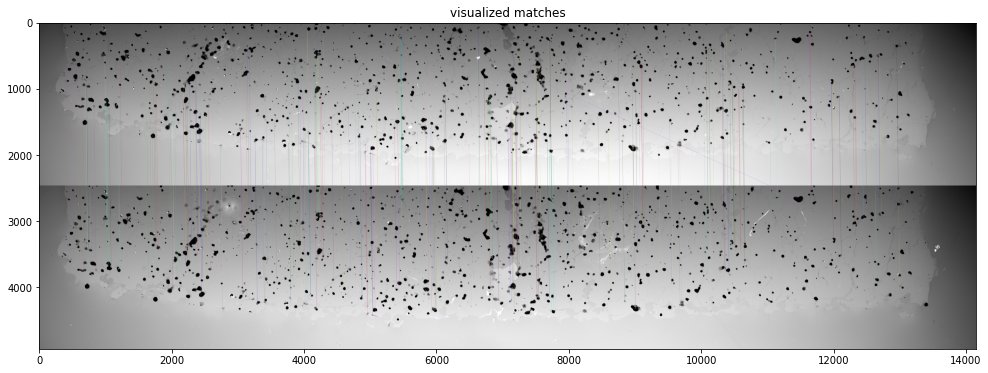

In [5]:
a, b = kl.get_min_dim(files['before']['data'], files['after']['data'])

"""
# use if image is loaded without flipping it vertically
x0 = 0000 + 12000
x1 = 2000 + 12000 #full_aligned.shape[0]
"""
x0 = 0#000 + 8500
x1 = a#5000 + 8500 #full_aligned.shape[0]
# use full height
y0 = 0#000
y1 = b#2464 #full_aligned.shape[1]

files['before']['thumb'] = files['before']['thumb'][x0:x1,y0:y1]
files['after']['thumb']  = files['after']['thumb'][x0:x1,y0:y1]
files['before']['data']  = files['before']['data'][x0:x1,y0:y1]
files['after']['data']   = files['after']['data'][x0:x1,y0:y1]

#kl.plot_image(files['before']['data'], "difference between images", files['before']['scale'])

H, aligned = kl.align_images(files['before']['thumb'], files['after']['thumb'])
(h, w) = files['before']['data'].shape[:2]
full_aligned = cv2.warpPerspective(files['before']['data'], H, (w, h))

difference = files['after']['data'][0:full_aligned.shape[0],0:full_aligned.shape[1]]-full_aligned[0:full_aligned.shape[0],0:full_aligned.shape[1]]

cropping images from 14149 x 2464 to 14099 x 2364


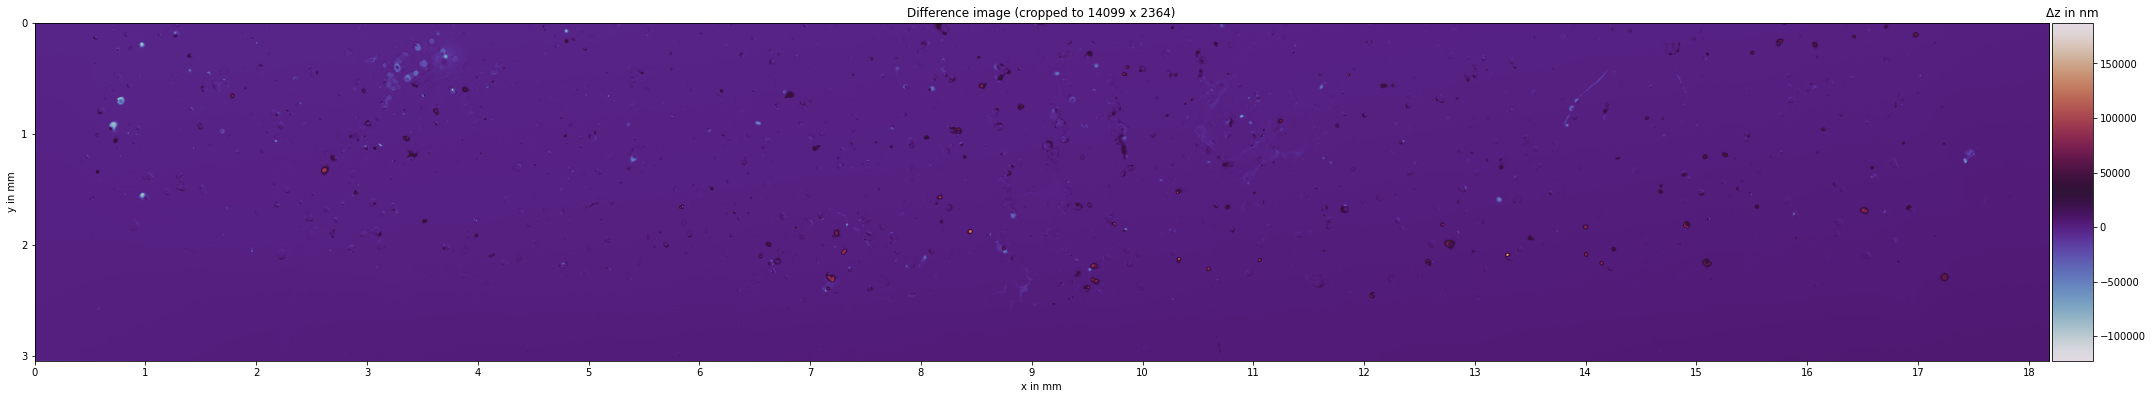

In [6]:
# cropping images
# due to the alignment, the images have some "not-overlapping" areas, which are cut off using manually chosen values:
cx = difference.shape[0]-50
cy = difference.shape[1]-100
print("cropping images from {} x {} to {} x {}".format(difference.shape[0], difference.shape[1], cx, cy))
difference   = difference[0:cx, 0:cy]
full_aligned = full_aligned[0:cx, 0:cy]
files['before']['data'] = files['before']['data'][0:cx, 0:cy]

kl.plot_image(difference, "Difference image (cropped to {} x {})".format(difference.shape[0], difference.shape[1]), files['after']['scale'], cmap='twilight')

modifying mask - removing very deviating pixels


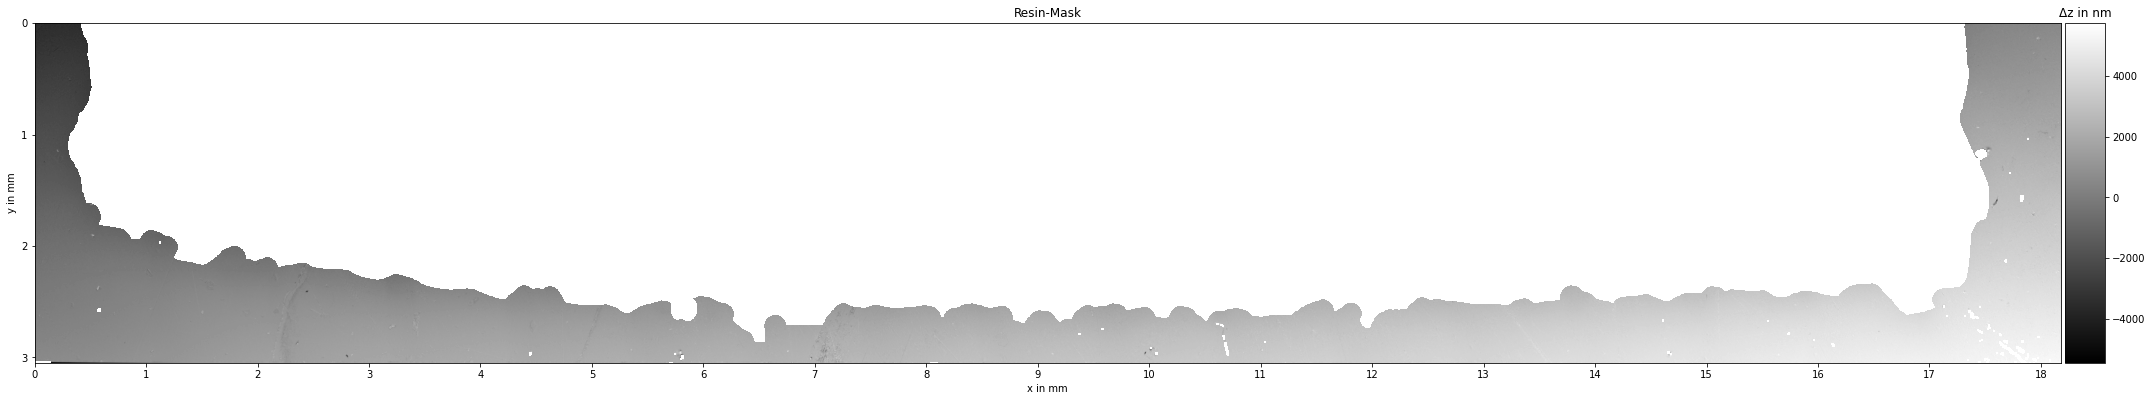

using 86877 points to extract the correction plane. Used every 100th point.


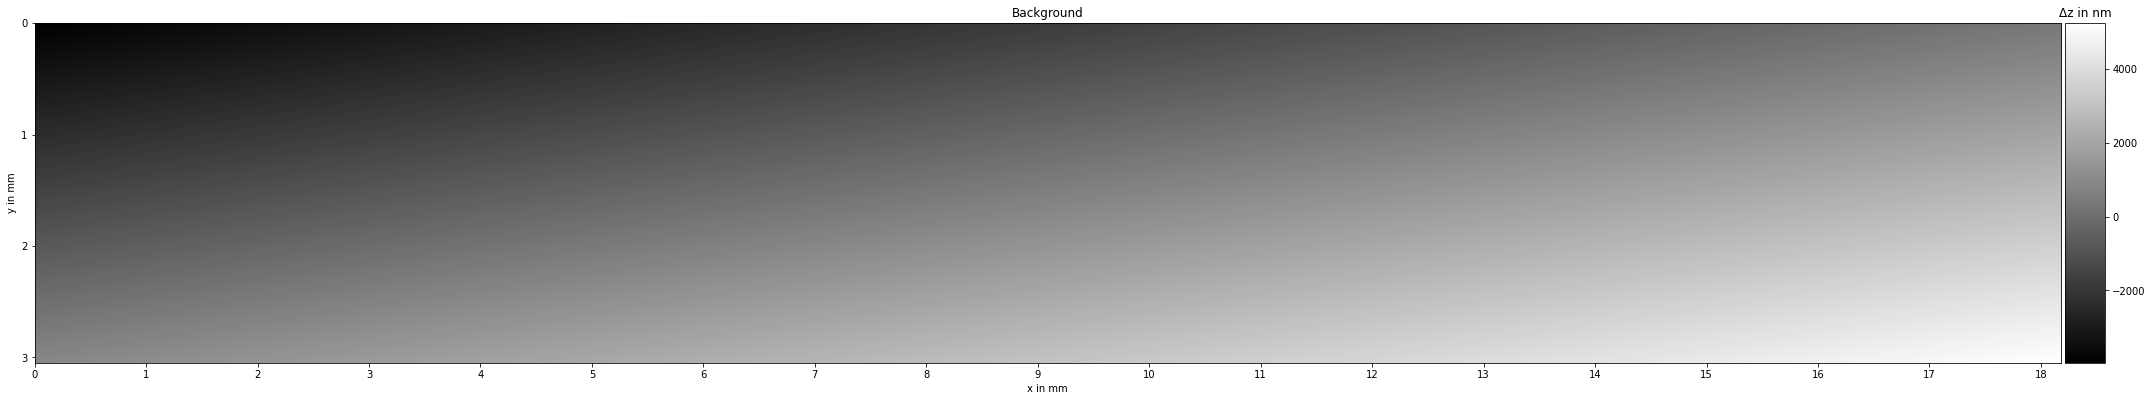

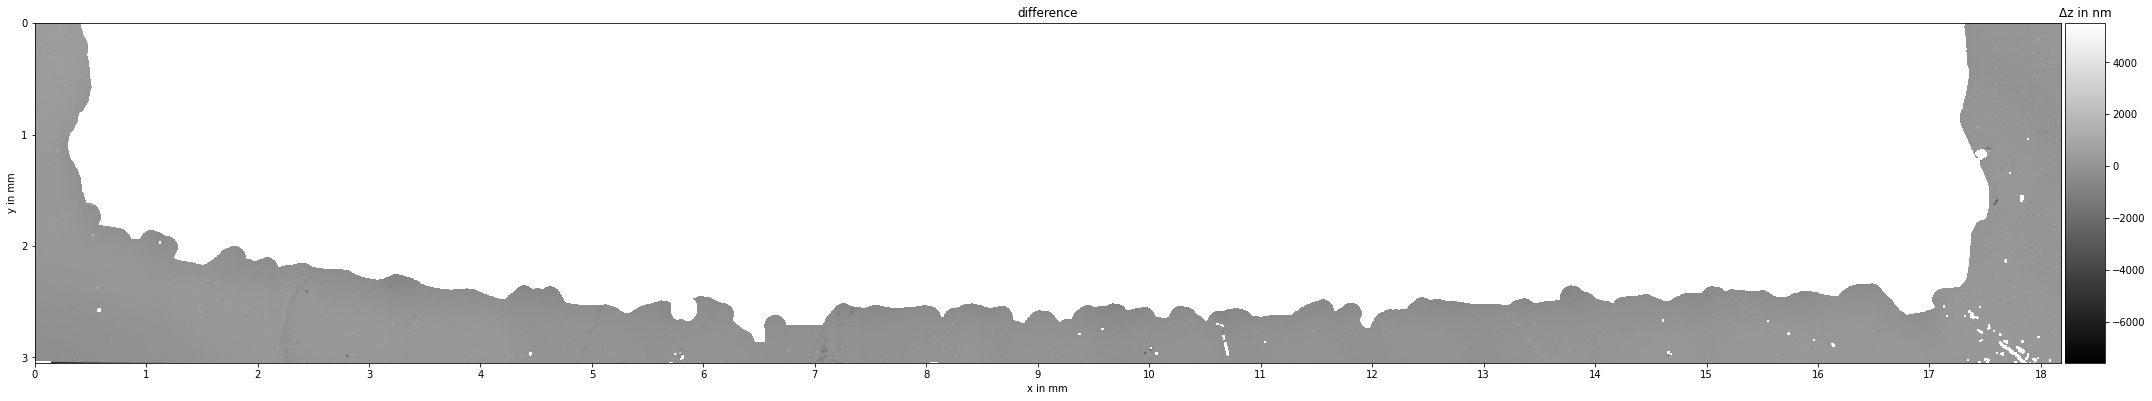

In [7]:
mask_filename = 'after-resin-mask.png'
# mask_filename			- filename of the mask, which defines, which areas should be used to calculate the correction plane
# difference			- aligned difference image
# scale					- scale from a file object containing 
# nth_point				- use the crossing point of every nth row/column to get points used to calculate the correction plane.
# median_filter_kernel	- use a median filter if the value is > 1. The filter will be processed on a smaller image, resizing is defined by nth_point
resin_mask, background = kl.get_background_correction(mask_filename, difference, files['after']['scale'], nth_point = 10, median_filter_kernel = 1)

In [8]:
a, b = kl.get_min_dim(background, files['after']['data'])
result = files['after']['data'][:a,:b]-background[:a,:b]

#corrected_difference = full_aligned-result

a, b = kl.get_min_dim(background, difference)
corrected_difference = difference[:a,:b]-background[:a,:b]

before 0.0 166688.71440039063
after 0.0 125275.445
difference between images 4.609375082509359e-06 4197.6353325
background 3.635225015354959e-05 5238.940681470824
before with bg-correction 6.170391702653433e-05 123097.31282499396
corrected difference 2.7397373742132913e-05 1196.444787512296


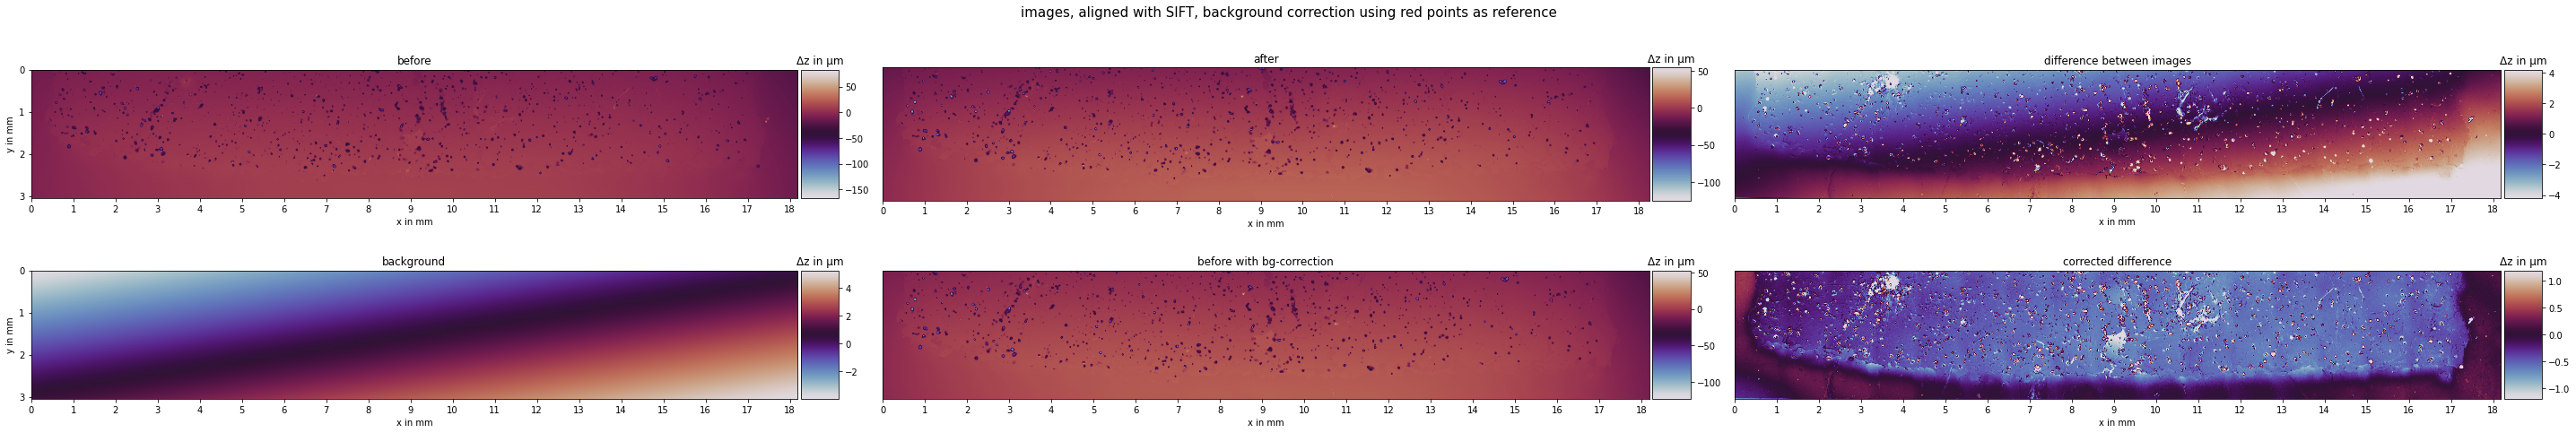

In [9]:
cmap		 = 'twilight'

images = {	"before": full_aligned, 
			"after":  files['after']['data'],
			"difference between images": difference,
			"background":background, 
			"before with bg-correction": result,
			"corrected difference": corrected_difference
		}
clip = {	"before": [0,100], 
			"after":  [0,100],
			"difference between images": [0,95],
			"background": [0,100], 
			"before with bg-correction": [0,100],
			"corrected difference": [0,95]
		}

	
ticks_f, labels_f = kl.get_ticks_in_mm( files['after']['scale'], distance=1, low_label_limit=0, high_limit=20 )

# Initialise the subplot function using number of rows and columns
fig, axis = plt.subplots(2, int(len(images)/2), figsize = (40,7))
i=0
for title, img in images.items():
	clip_min, clip_max = np.percentile(np.abs(img), clip[title], method='lower')
	print(title, clip_min, clip_max)
	j = 0 if i < int(len(images)/2) else 1
	k = i if i < int(len(images)/2) else i-int(len(images)/2)
	im_show = np.rot90(np.clip(img, -clip_max, clip_max)/1000)
	plot = axis[j,k].imshow( im_show, cmap=cmap )

	axis[j,k].set_title(title)
	ticks, labels = kl.filter_label( ticks_f, labels_f, im_show.shape[1] )
	axis[j,k].set_xticks(ticks, labels)
	axis[j,k].set_xlabel('x in mm')
	if ( k == 0 ):
		ticks, labels = kl.filter_label( ticks_f, labels_f, im_show.shape[0] )
		axis[j,k].set_yticks(ticks, labels)
		axis[j,k].set_ylabel('y in mm')
	else: axis[j,k].set_yticks([])

	clb = fig.colorbar(plot, cax=make_axes_locatable(axis[j,k]).append_axes('right', size='5%', pad=0.05), orientation='vertical')
	clb.ax.set_title('Δz in µm')
	i += 1

fig.suptitle("images, aligned with SIFT, background correction using red points as reference", fontsize=15)
plt.tight_layout()
plt.show()

-193.10003024991454


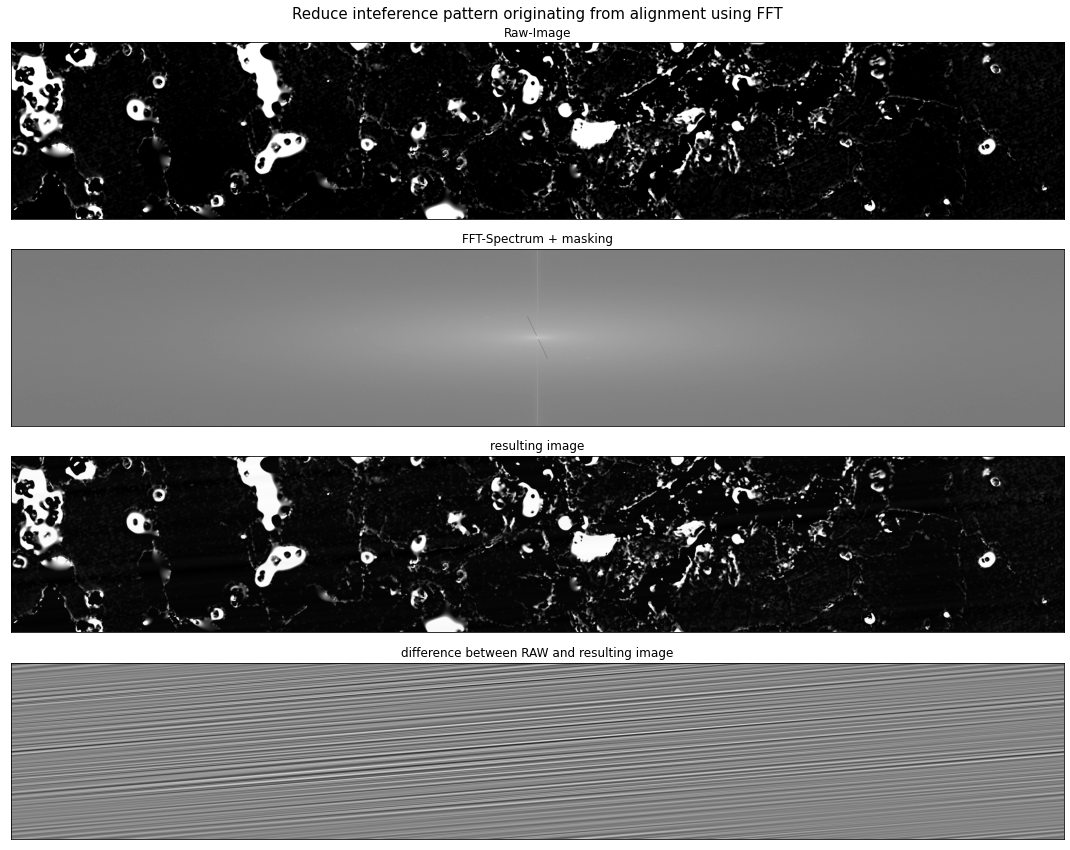

In [10]:
clip_max= 800

zero_resin = np.mean( np.ma.array( corrected_difference, mask=np.rot90(resin_mask) ) )
print(zero_resin)

img = np.rot90( np.clip(corrected_difference+zero_resin, -clip_max, clip_max) )
#img = img[int(img.shape[0]*2/6):int(img.shape[0]*3/6), int(img.shape[1]*3/6):int(img.shape[1]*4/6)]

fshift = np.fft.fftshift( np.fft.fft2(img) )
magnitude_spectrum  = 20*np.log(np.abs(fshift))

# try to remove frequencies which appear due to the image alignment
mask = np.ones(img.shape,np.uint8)

"""
# use if image is loaded without flipping it vertically
mask = draw_line_on_fft_mask( [90, -185], [200, -400], mask, linewidth=3 )
#mask = draw_line_on_fft_mask( [200,-30], [500, -90], mask )
mask = draw_rect_on_fft_mask( [285,-95], mask )
mask = draw_rect_on_fft_mask( [115,-350], mask )
"""

#mask = kl.draw_line_on_fft_mask( [-90, -185], [-200, -400], mask, linewidth=3 )
#mask = kl.draw_rect_on_fft_mask( [-285,-135], mask )
#mask = kl.draw_rect_on_fft_mask( [-105,-410], mask, width=40 )
mask = kl.draw_line_on_fft_mask( [-285,-135], [-25, -12], mask, linewidth=2 )#[800, 260]

img_inv_fft = np.real( np.fft.ifft2( np.fft.ifftshift(fshift*mask) ) )

fig = plt.figure(figsize = (30,12),facecolor='white')
plt.subplot(411),plt.imshow( img[int(img.shape[0]*2/6):int(img.shape[0]*3/6), int(img.shape[1]*3/6):int(img.shape[1]*4/6)], cmap = 'gray')
#plt.subplot(131),plt.imshow( img, cmap = 'gray')
plt.title('Raw-Image'), plt.xticks([]), plt.yticks([])
plt.subplot(412),plt.imshow( (magnitude_spectrum*mask), cmap = 'gray')
plt.title('FFT-Spectrum + masking'), plt.xticks([]), plt.yticks([])
plt.subplot(413),plt.imshow( img_inv_fft[int(img.shape[0]*2/6):int(img.shape[0]*3/6), int(img.shape[1]*3/6):int(img.shape[1]*4/6)], cmap = 'gray')
plt.title('resulting image'), plt.xticks([]), plt.yticks([])
plt.subplot(414),plt.imshow( img_inv_fft-img, cmap = 'gray')
plt.title('difference between RAW and resulting image'), plt.xticks([]), plt.yticks([])
fig.suptitle("Reduce inteference pattern originating from alignment using FFT", fontsize=15)
plt.tight_layout()
plt.show()

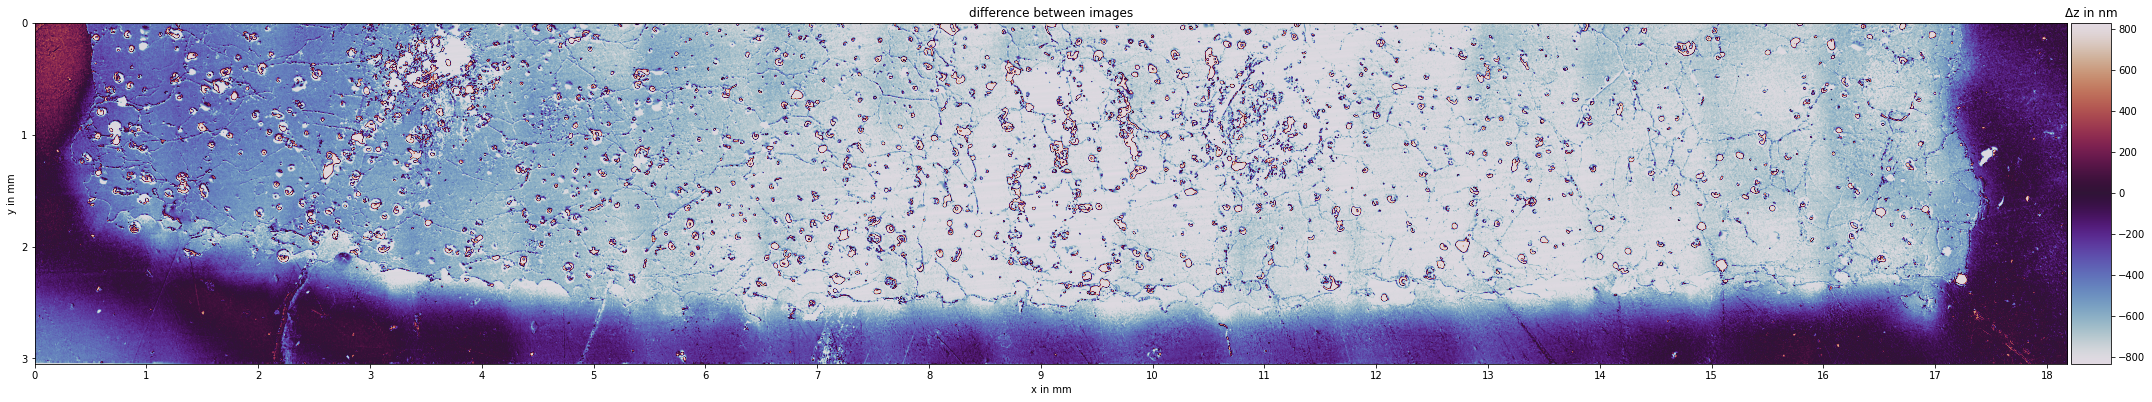

<Figure size 432x288 with 0 Axes>

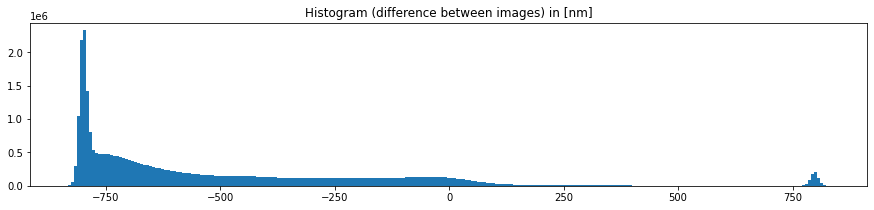

In [11]:
marker_color = "white"

disply_diff = np.clip(np.absolute(img_inv_fft), 0, clip_max)#[500:1000,500:1000]

#clip_min, clip_max = np.percentile(img, clip[title], method='lower')

zero_resin = np.mean( np.ma.array( img_inv_fft, mask=np.rot90(resin_mask) ) )

kl.plot_image(img_inv_fft, "difference between images", files['after']['scale'], cmap='twilight')

plt.tight_layout()
plt.show()

plt.figure(figsize = (15,3))
plt.hist((img_inv_fft).flatten(), bins=255) #, figsize=[30,5]
plt.title("Histogram (difference between images) in [{}]".format(files['before']['unit']))
plt.show()

In [12]:

points = np.array( [
	#(350, 200),
	#(250, 1550),
	#(1700,1700),
	#(1560,450)
	#(350, 200),
	(11500+2200,500),
	(11500+550, 2100),
	(11500+2200,2000),
	(11500+1200,2100),
	(11500+2200,1200),
] )
points = points.astype(int)

new point 200 200 -185 std dev: 30.55739906725021
new point 200 2150 487 std dev: 57.46805577049867
new point 13500 215 254 std dev: 101.92699387205582
847944.309743911 8960804.542983077 -25935000.0 -6781558866.926969


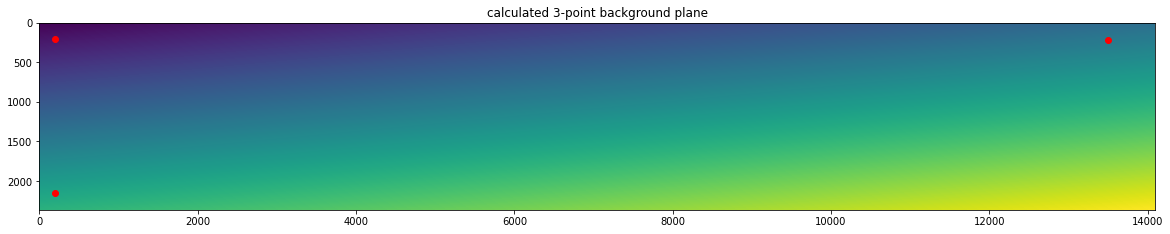

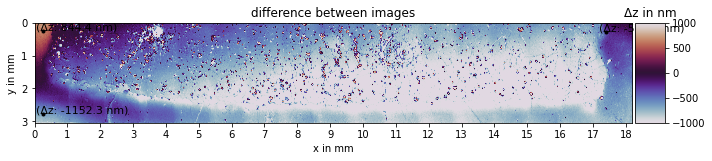

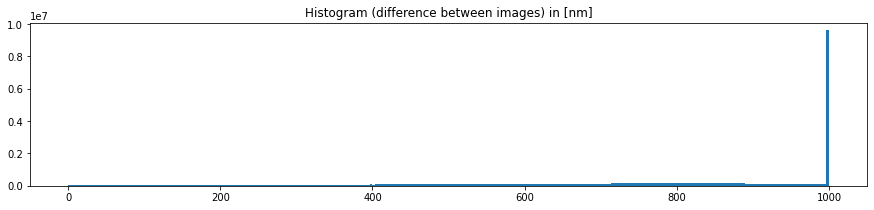

In [13]:
clip_max= 1000

background, points = kl.get_plane(corrected_difference, (200, 200), (200, 2150), (13500,215), buffer = 5 ) # (13500,500),
#background, points = kl.get_plane(corrected_difference, points[0],points[1],points[2], buffer = buffer )

img_inv_fft_corr = np.rot90( corrected_difference )-background

marker_color = "black"

disply_diff = np.clip((img_inv_fft_corr), -clip_max, clip_max)#[500:1000,500:1000]

clip_min, clip_max = np.percentile(img_inv_fft_corr, clip[title], method='lower')
ticks_f, labels_f = kl.get_ticks_in_mm( files['after']['scale'], distance=1, low_label_limit=0, high_limit=20 )

fig, axis = plt.subplots(1,1, figsize = (10,10))
plot = axis.imshow( disply_diff, cmap='twilight' )

ticks, labels = kl.filter_label( ticks_f, labels_f, img_inv_fft_corr.shape[1] )
axis.set_xticks(ticks, labels)
axis.set_xlabel('x in mm')

ticks, labels = kl.filter_label( ticks_f, labels_f, img_inv_fft_corr.shape[0] )
axis.set_yticks(ticks, labels)
axis.set_ylabel('y in mm')

for i, p in enumerate(points):
	axis.plot(p[0], p[1], marker='.', color=marker_color)
	delta = img_inv_fft_corr[int(p[1]), int(p[0])]-p[2]
	#txt = '({:.0f} {:.0f} {:.0f} ,d:{:.1f} nm)'.format(p[1], p[0], p[2], delta)
	txt = '(Δz: {:.1f} nm)'.format(delta)
	axis.text(p[0]-175, p[1]-20, txt, fontsize=11, color=marker_color)

axis.set_title("difference between images")
#axis.set_xticks([])
#axis.set_yticks([])

clb = fig.colorbar(plot, cax=make_axes_locatable(axis).append_axes('right', size='5%', pad=0.05), orientation='vertical')
clb.ax.set_title('Δz in nm')

plt.tight_layout()
plt.show()

#kl.plot_image(img_inv_fft, "difference between images", files['after']['scale'], cmap='twilight')


plt.figure(figsize = (15,3))
plt.hist(np.absolute(disply_diff).flatten(), bins=255) #, figsize=[30,5]
plt.title("Histogram (difference between images) in [{}]".format(files['before']['unit']))
plt.show()